### Importing the dataset

In [ ]:
from datasets import load_dataset

In [ ]:
emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Tokenizing the Dataset

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding = True, truncation = True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Training a Classifier

In [ ]:
from transformers import AutoModel
import torch
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

#### Extracting the last hidden states

In [ ]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Creating a feature matrix

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((16000, 768), (2000, 768), (16000,), (2000,))

### Visualizing Data

In [ ]:
from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_Scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components = 2, metric = "cosine").fit(X_Scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns = ["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.574421,6.177629,0
1,-3.031460,5.247735,0
2,5.266523,2.746444,3
3,-2.105354,3.406076,2
4,-3.195468,3.482177,3


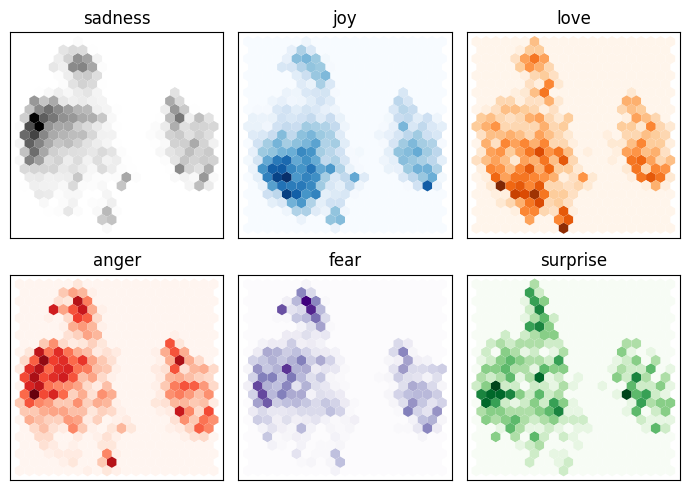

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap = cmap, gridsize = 20, linewidths = (0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a Simple Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.522
